In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
unemp_data = pd.read_csv('../../../Data/unemp_rate.csv')
unemp_data.head()


,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [3]:
unemp_data.isnull().values.any()


False

In [4]:
unemp_data['conv'] = pd.to_datetime(unemp_data.DATE)
unemp_data.head()

,DATE,UNRATE,conv
0,1948-01-01,3.4,1948-01-01
1,1948-02-01,3.8,1948-02-01
2,1948-03-01,4.0,1948-03-01
3,1948-04-01,3.9,1948-04-01
4,1948-05-01,3.5,1948-05-01


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


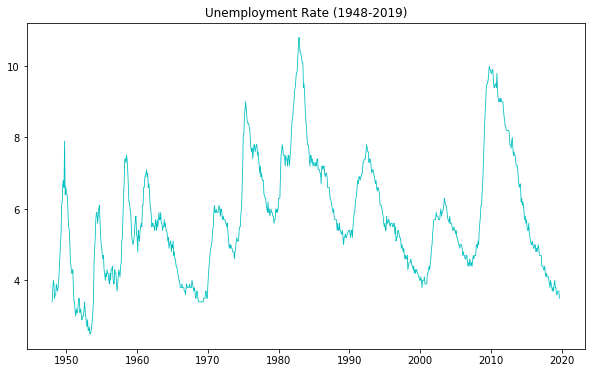

In [5]:
plt.figure(figsize=(10, 6))
plt.plot('conv', 'UNRATE', data=unemp_data, color='c', linewidth=0.8)
plt.title('Unemployment Rate (1948-2019)')
plt.show()

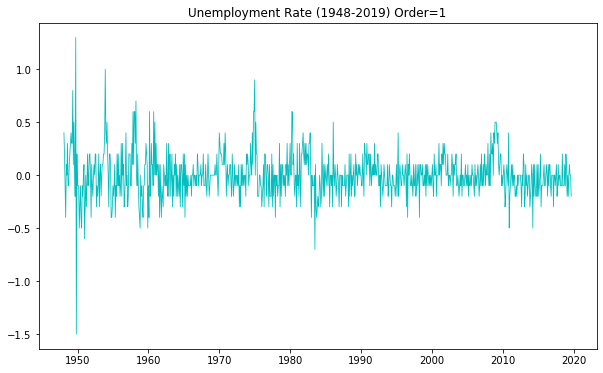

In [11]:
unemp_data['diff_1'] = unemp_data.UNRATE - unemp_data.UNRATE.shift()
plt.figure(figsize=(10, 6))
plt.plot('conv', 'diff_1', data=unemp_data, color='c', linewidth=0.8)
plt.title('Unemployment Rate (1948-2019) Order=1')
plt.show()

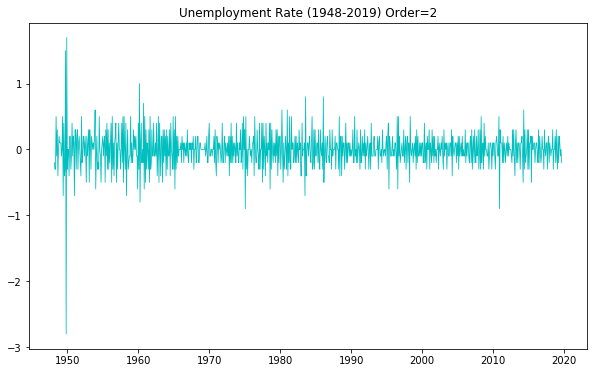

In [12]:
# let's try differencing one more order
unemp_data['diff_2'] = unemp_data.diff_1 - unemp_data.diff_1.shift()
plt.figure(figsize=(10, 6))
plt.plot('conv', 'diff_2', data=unemp_data, color='c', linewidth=0.8)
plt.title('Unemployment Rate (1948-2019) Order=2')
plt.show()

It seems pretty stationary now. So I in ARIMA we will use will be 2.

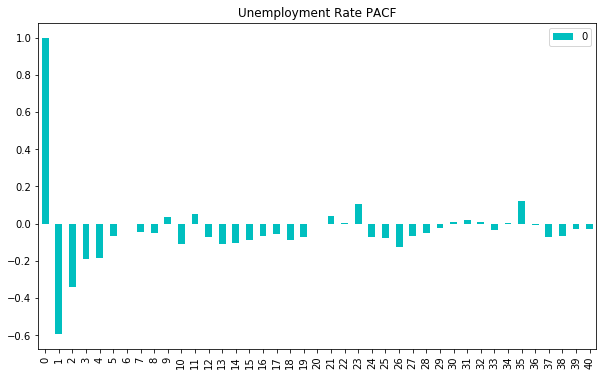

In [21]:
from statsmodels.tsa.stattools import pacf
p = pacf(unemp_data.diff_2[2:])
x_pacf = pd.DataFrame(p)
x_pacf.plot(kind='bar', figsize=(10, 6), color='c')
plt.title("Unemployment Rate PACF")
plt.show()

1 shows a strong autocorrelation. Since PACF is a good measure of best order of lag for autoregression, we will use AR(1). Let's see the moving average plot.

[ 1.         -0.5936988   0.13437119 -0.01492472 -0.04311532  0.07662843
 -0.03458603 -0.02559543  0.02194005  0.03047042 -0.10649389  0.1623998
 -0.1742905   0.07662624 -0.00838345 -0.01569825  0.02955309 -0.0271243
 -0.01584636  0.03199488  0.01994349 -0.02390375  0.0088349   0.03382089
 -0.10435901  0.09247663 -0.06855107  0.06444475 -0.02665989 -0.00456637
  0.02407275 -0.01477684 -0.00898659 -0.01691077  0.05225161 -0.00106137
 -0.04676657 -0.00106564  0.03306117 -0.00365449 -0.0105165 ]


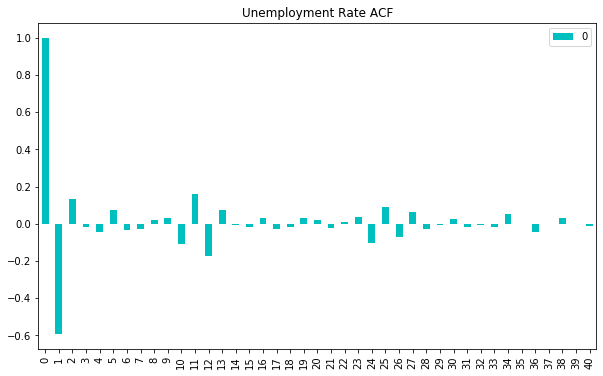

In [23]:
from statsmodels.tsa.stattools import acf
a = acf(unemp_data.diff_2[2:])
print(a)
x_acf = pd.DataFrame(a)
x_acf.plot(kind='bar', figsize=(10, 6), color='c')
plt.title("Unemployment Rate ACF")
plt.show()

Best order of MA looks to be 1 according to the acf plot. Let's proceed to building our model with this combination.

In [24]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(unemp_data.UNRATE, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:              D2.UNRATE   No. Observations:                  859
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 159.354
Method:                       css-mle   S.D. of innovations              0.201
Date:                Mon, 07 Oct 2019   AIC                           -310.709
Time:                        13:04:48   BIC                           -291.686
Sample:                             2   HQIC                          -303.426
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0002      0.002     -0.110      0.912      -0.003       0.003
ar.L1.D2.UNRATE    -0.2232      0.045     -5.009      0.000      -0.311      -0.136
ma.L1.D2.UNRATE    -0.6996      

Let's compare the AIC for ARIMA(1,2,1) with a couple others.

In [25]:
model = ARIMA(unemp_data.UNRATE, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  860
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 169.546
Method:                       css-mle   S.D. of innovations              0.199
Date:                Mon, 07 Oct 2019   AIC                           -331.091
Time:                        13:07:02   BIC                           -312.063
Sample:                             1   HQIC                          -323.806
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0004      0.015      0.029      0.977      -0.029       0.029
ar.L1.D.UNRATE     0.8711      0.029     29.622      0.000       0.813       0.929
ma.L1.D.UNRATE    -0.7175      0.038

In [26]:
model = ARIMA(unemp_data.UNRATE, order=(0,1,0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:               D.UNRATE   No. Observations:                  860
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 129.373
Method:                           css   S.D. of innovations              0.208
Date:                Mon, 07 Oct 2019   AIC                           -254.746
Time:                        13:07:26   BIC                           -245.232
Sample:                             1   HQIC                          -251.103
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.007      0.016      0.987      -0.014       0.014
Residuals Description
count    8.600000e+02
mean     1.519754e-09
std      2.082970e-01
min     -1.500116e+00
25%     -1.001163e-01

In [27]:
print(np.exp(((-310)-(-331))/2))
print(np.exp((19193-19204)/2))

36315.502674246636
0.004086771438464067
